### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

### Loading the data

In [2]:
data = pd.read_csv('data.csv')
data.head()

,pregnancies,Plasma glucose,Diastolic blood pressure,Triceps skinfold thickness,serum insulin,Body mass index,Diabetes pedigree function,Age,Class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### EDA

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   pregnancies                 768 non-null    int64  
 1   Plasma glucose              768 non-null    int64  
 2   Diastolic blood pressure    768 non-null    int64  
 3   Triceps skinfold thickness  768 non-null    int64  
 4   serum insulin               768 non-null    int64  
 5   Body mass index             768 non-null    float64
 6   Diabetes pedigree function  768 non-null    float64
 7   Age                         768 non-null    int64  
 8   Class                       768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


#### Observations
- No missing values.
- No categorical variables.

In [4]:
data.describe()

,pregnancies,Plasma glucose,Diastolic blood pressure,Triceps skinfold thickness,serum insulin,Body mass index,Diabetes pedigree function,Age,Class
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


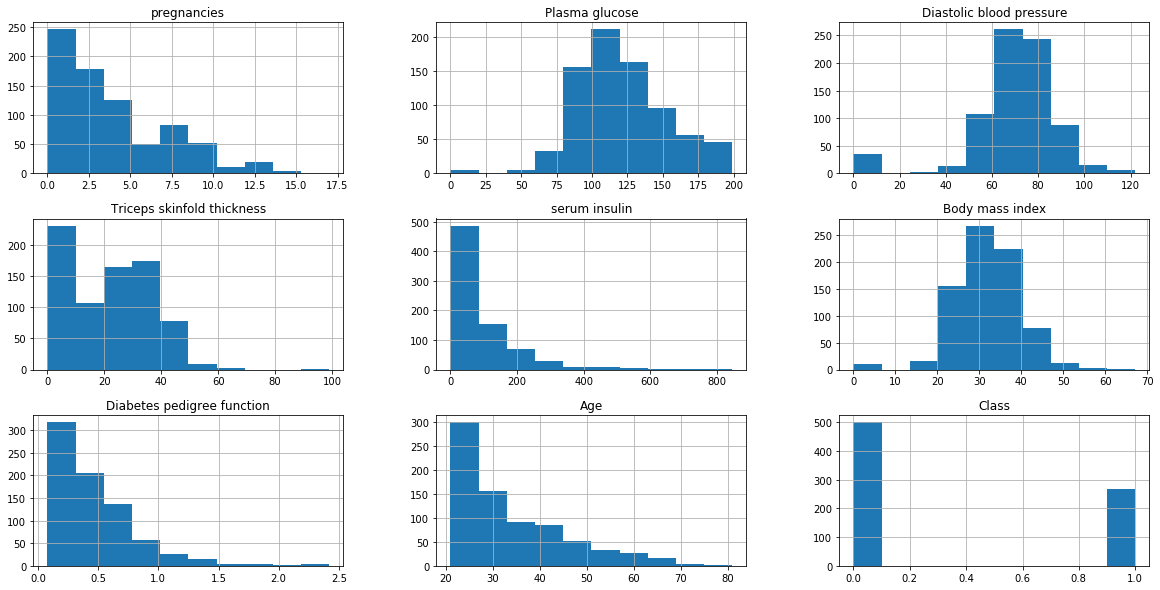

In [5]:
data.hist(figsize=(20, 10))
plt.show()

#### Observations
- The columns Number of pregnancies, Triceps skinfold thickness, Serum insulin, Diabetes pedigree function and Age are right skewed.
- The columns Plasma glucose, Diastolic blood pressure and Body mass index have a normal distibution.
- The target variable is imbalanced.

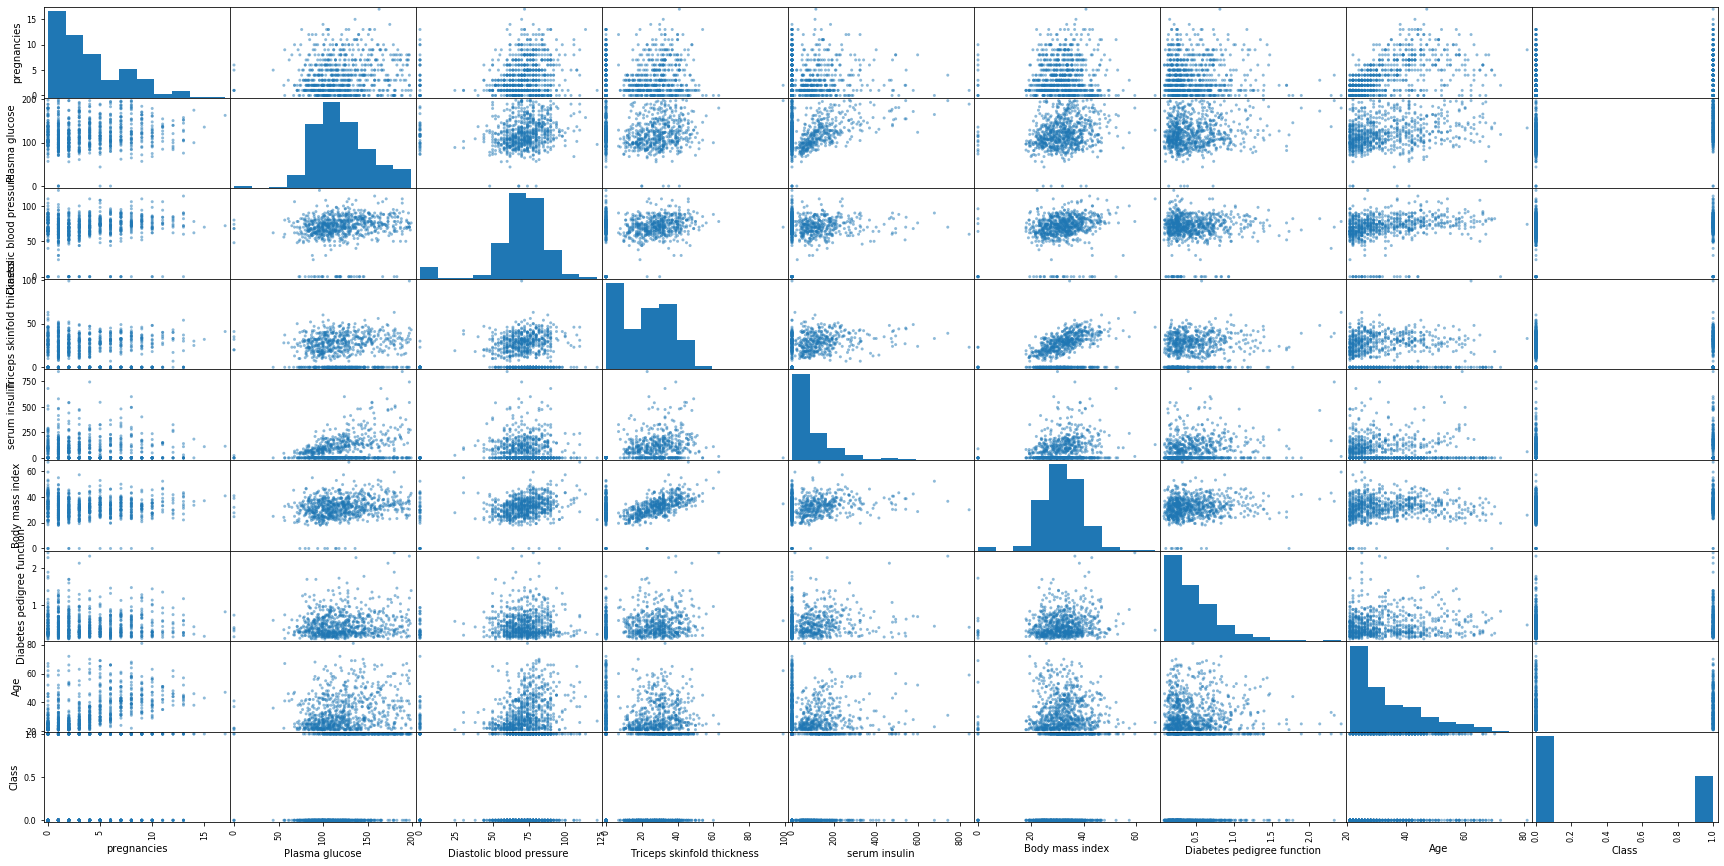

In [6]:
pd.plotting.scatter_matrix(data,figsize=(30, 15))
plt.show()

### Spliting the data

In [7]:
from sklearn.model_selection import train_test_split

X_training, X_test, y_training, y_test = train_test_split(data.iloc[:,:-1], data.iloc[:,-1],
                                                          test_size=0.1,
                                                          random_state = 42)


### Creating Pipeline for simple Logistic regression.

In [8]:
num_columns = ['Plasma glucose','Diastolic blood pressure','Body mass index']
log_columns = ['Triceps skinfold thickness', 'serum insulin','pregnancies','Diabetes pedigree function', 'Age']

def log_transform(x):
    return np.log(x + 1)
               
from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(log_transform)
               
num_pipeline = Pipeline([('standardize_num', StandardScaler())
                        ])

log_pipeline = Pipeline([('log_transform', transformer)
                        ])

processing_pipeline = ColumnTransformer(transformers=[('proc_numeric', num_pipeline, num_columns),
                                                      ('log_transform', log_pipeline, log_columns)])

print(processing_pipeline)

ColumnTransformer(transformers=[('proc_numeric',
                                 Pipeline(steps=[('standardize_num',
                                                  StandardScaler())]),
                                 ['Plasma glucose', 'Diastolic blood pressure',
                                  'Body mass index']),
                                ('log_transform',
                                 Pipeline(steps=[('log_transform',
                                                  FunctionTransformer(func=<function log_transform at 0x000001C8D85D5790>))]),
                                 ['Triceps skinfold thickness', 'serum insulin',
                                  'pregnancies', 'Diabetes pedigree function',
                                  'Age'])])


In [9]:
from sklearn.linear_model import LogisticRegression

modeling_pipeline = Pipeline([('data_processing', processing_pipeline), ('lr', LogisticRegression(max_iter=5000))])
modeling_pipeline.fit(X_training, y_training)

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('standardize_num',
                                                                   StandardScaler())]),
                                                  ['Plasma glucose',
                                                   'Diastolic blood pressure',
                                                   'Body mass index']),
                                                 ('log_transform',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<function log_transform at 0x000001C8D85D5790>))]),
                                                  ['Triceps skinfold thickness',
                                                   'serum insulin',
                                                   'pregnanc

### Model evaluation

In [10]:
from sklearn.metrics import confusion_matrix

y_test_pred = modeling_pipeline.predict(X_test)
print(confusion_matrix(y_test, y_test_pred))

[[38 12]
 [10 17]]


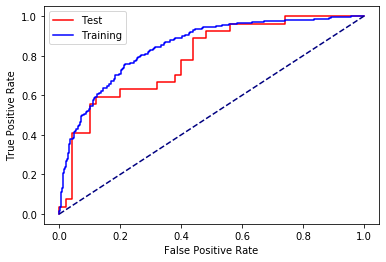

In [11]:
from sklearn.metrics import roc_curve

def generate_probs(X, model=modeling_pipeline):
    return model.predict_proba(X)[:, 1]

def generate_roc(y, probs):
    fpr, tpr, _ = roc_curve(y, probs)
    return fpr, tpr
    
fpr_test, tpr_test = generate_roc(y_test, generate_probs(X_test))
fpr_train, tpr_train = generate_roc(y_training, generate_probs(X_training))

plt.plot(fpr_test, tpr_test,'-r')
plt.plot(fpr_train, tpr_train,'-b')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Test','Training'])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.show()

In [12]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.79      0.76      0.78        50
           1       0.59      0.63      0.61        27

    accuracy                           0.71        77
   macro avg       0.69      0.69      0.69        77
weighted avg       0.72      0.71      0.72        77



#### Observations
- The accuracy of the model is 69.6%
- As the target variable is unbalanced I am selecting recall as a measure to determine the performance of the model.
- Out of 100 0's the model can recall 76 of them and out of 100 1's the model can recall 63 of them.

### Creating Pipeline for Logistic regression with Grid search view using accuracy

In [13]:
modeling_pipeline2 = Pipeline([('data_processing', processing_pipeline), ('lr2', LogisticRegression(max_iter=5000))])
param_grid = [
  {'lr2__class_weight': [None, 'balanced'], 'lr2__C':[0.01, 0.1, 1, 10, 100],'lr2__solver':['liblinear','sag','saga']}
 ]
gcv_results = GridSearchCV(estimator=modeling_pipeline2, param_grid=param_grid, scoring=['accuracy', 'recall', 'precision', 'f1_macro', 'roc_auc'], cv=10, refit='accuracy')
gcv_results = gcv_results.fit(X_training, y_training)

In [14]:
gcv_results.best_score_

0.7771014492753624

In [15]:
gcv_results.best_params_

{'lr2__C': 1, 'lr2__class_weight': None, 'lr2__solver': 'liblinear'}

In [16]:
y_testp = gcv_results.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_testp))

              precision    recall  f1-score   support

           0       0.79      0.84      0.82        50
           1       0.67      0.59      0.63        27

    accuracy                           0.75        77
   macro avg       0.73      0.72      0.72        77
weighted avg       0.75      0.75      0.75        77



#### Observations
- For the grid search with accuracy as the main evaluation criteria the model has a best score of 0.777. 
- The best set of hyperparameters for this model are C : 1, Class weight : None, and solver : loblinear

### Creating Pipeline for Logistic regression with Grid search view using recall

In [17]:
modeling_pipeline3 = Pipeline([('data_processing', processing_pipeline), ('lr2', LogisticRegression(max_iter=5000))])
param_grid = [
  {'lr2__class_weight': [None, 'balanced'], 'lr2__C':[0.01, 0.1, 1, 10, 100],'lr2__solver':['liblinear','sag','saga']}
 ]
gcv_results2 = GridSearchCV(estimator=modeling_pipeline3, param_grid=param_grid, scoring=['accuracy', 'recall', 'precision', 'f1_macro', 'roc_auc'], cv=10, refit='recall')
gcv_results2 = gcv_results2.fit(X_training, y_training)

In [18]:
gcv_results2.best_score_

0.7384999999999999

In [19]:
gcv_results2.best_params_

{'lr2__C': 1, 'lr2__class_weight': 'balanced', 'lr2__solver': 'sag'}

In [20]:
y_testp2 = gcv_results2.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_testp2))

              precision    recall  f1-score   support

           0       0.81      0.60      0.69        50
           1       0.50      0.74      0.60        27

    accuracy                           0.65        77
   macro avg       0.66      0.67      0.64        77
weighted avg       0.70      0.65      0.66        77



#### Observations
- For the grid search with recall as the main evaluation criteria the model has a best score of 0.738. 
- The best set of hyperparameters for this model are C : 1, Class weight : balanced, and solver : sag.
- Despite a lower score compared to the previous model the second model performs better for classification.